In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [141]:
def advect_linear_slopes(qc, ui, sc, dt, dx, N, QL, QR):
    """
    qc : density
    ui : speeds at interfaces
    sc : slopes at centers
    dt : dt
    dx : dx
    """
    F = np.zeros_like(ui)
    q = np.zeros_like(qc)

    q[0] = QL# qc[N-2]
    q[N-1] =QR# qc[1]
    
    mask_pos = ui[1:-1] > 0
    mask_neg = ui[1:-1] < 0

    F[1:-1][mask_pos] = ui[1:-1][mask_pos] * (qc[:-1][mask_pos] - (0.5 * sc[:-1][mask_pos] * (dx + ui[1:-1][mask_pos] * dt)))
    F[1:-1][mask_neg] = ui[1:-1][mask_neg] * (qc[1: ][mask_neg] - (0.5 * sc[1: ][mask_neg] * (dx + ui[1:-1][mask_neg] * dt)))

    q[1:-1] = qc[1:-1] - (dt/dx) * (F[2:-1] - F[1:-2])
    
    return q

N = 100
Nt = 1000

dt = 0.05
dx = 8 / N

xc = np.linspace(-4, 4, N)
xi = np.linspace(-4, 4, N+1)
qc = 1 + norm.pdf(xc, loc=-2, scale=0.5)
ui = np.ones((N+1))
sc = np.zeros((N))

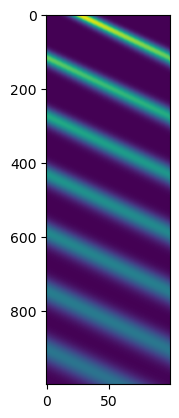

In [115]:
T = 1000
rhomat = np.zeros((T, N))
for n in range(T):
    qc = advect_linear_slopes(qc, ui, sc, dt, dx, N)
    rhomat[n, :] = qc

plt.imshow(rhomat, aspect=0.3)
plt.show()

# This should be identical to Lax-Wendroff

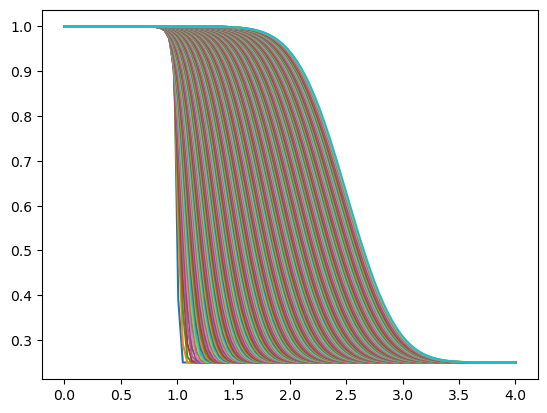

In [168]:
T = 200
xc = np.linspace(0, 4, N)
xi = np.linspace(0, 4, N+1)
ui = np.ones((N+1))
sc = np.zeros((N))


TV = np.zeros((T))


dt = 3 / 200

def init_rho(x):
    rho = np.ones((N)) * 0.25
    mask = x <= 1
    rho[mask] = 1.0
    return rho

qc = init_rho(xc)

rhomat = np.zeros((T, N))
for n in range(T):
    qc = advect_linear_slopes(qc, ui, sc, dt, dx, N, 1, 0.25)
    sc[1:-1] = (qc[2:] - qc[1:-1])/dx

    plt.plot(xc, qc)
    rhomat[n, :] = qc
    TV[n] = np.sum(np.abs(qc[1:] - qc[0:-1]))

# seems to work ok

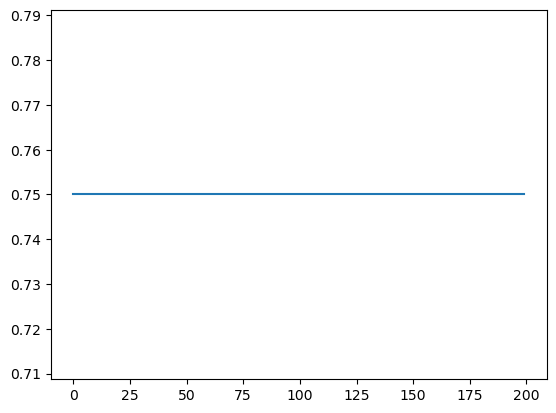

In [169]:
plt.plot(TV)

# This should be the beam warming scheme (up-wind)

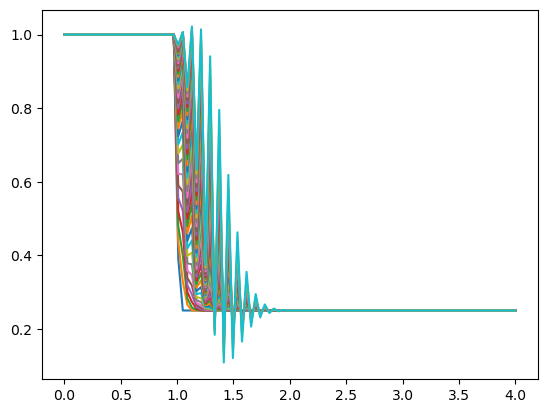

In [170]:
T = 40
xc = np.linspace(0, 4, N)
xi = np.linspace(0, 4, N+1)
ui = np.ones((N+1))
sc = np.zeros((N))


dt = 3 / 200

def init_rho(x):
    rho = np.ones((N)) * 0.25
    mask = x <= 1
    rho[mask] = 1.0
    return rho

qc = init_rho(xc)
TV = np.zeros((T))

rhomat = np.zeros((T, N))
for n in range(T):
    qc = advect_linear_slopes(qc, ui, sc, dt, dx, N, 1, 0.25)
    sc[1:] = (qc[1:] - qc[0:-1])/(dx)

    TV[n] = np.sum(np.abs(qc[1:] - qc[0:-1]))

    if (n % 1 == 0):
        plt.plot(xc, qc)
    rhomat[n, :] = qc

# seems to work ok, a little bit more diffusive than the previous scheme

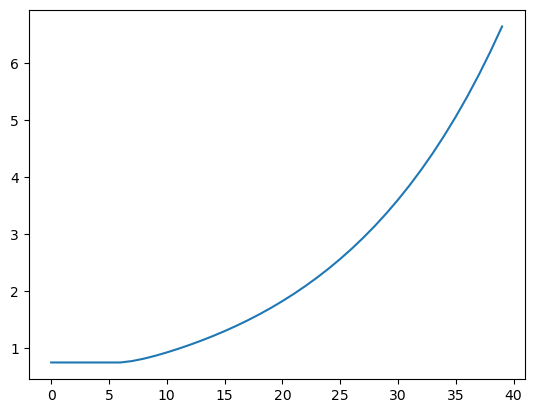

In [171]:
plt.plot(TV)

# And this should be the Fromm scheme (symmetric)

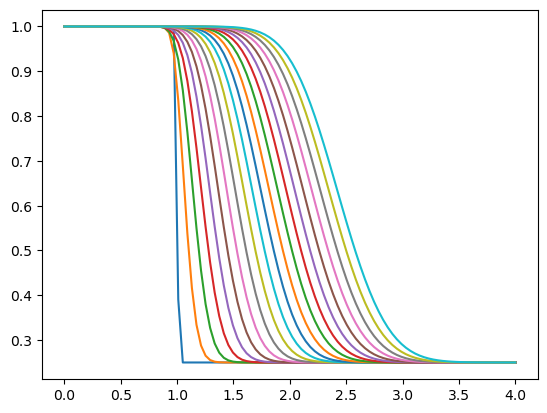

In [181]:
T = 200
xc = np.linspace(0, 4, N)
xi = np.linspace(0, 4, N+1)
ui = np.ones((N+1))
sc = np.zeros((N))


dt = 3 / 200

def init_rho(x):
    rho = np.ones((N)) * 0.25
    mask = x <= 1
    rho[mask] = 1.0
    return rho

qc = init_rho(xc)
#qc = norm.pdf(xc, loc=0, scale=0.5)
TV = np.zeros((T))

rhomat = np.zeros((T, N))
for n in range(T):
    qc = advect_linear_slopes(qc, ui, sc, dt, dx, N, 1, 0.25)
    sc[1:-1] = (qc[2:] - qc[0:-2])/(2*dx)

    TV[n] = np.sum(np.abs(qc[1:] - qc[0:-1]))

    if (n % 10 == 0):
        plt.plot(xc, qc)
    rhomat[n, :] = qc

# seems to work ok, a little bit more diffusive than the previous scheme

# Total variation remains constant for this case

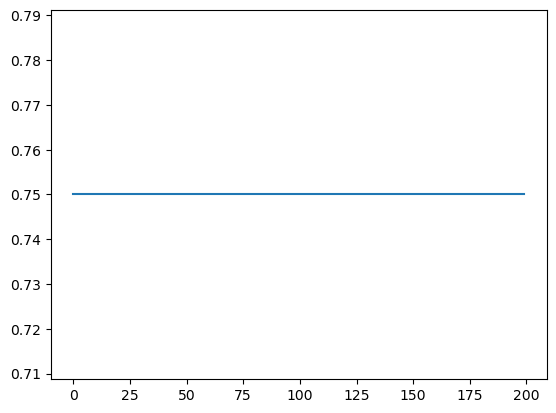

In [182]:
plt.plot(TV)


# More testing of the Fromm method with a different initial density

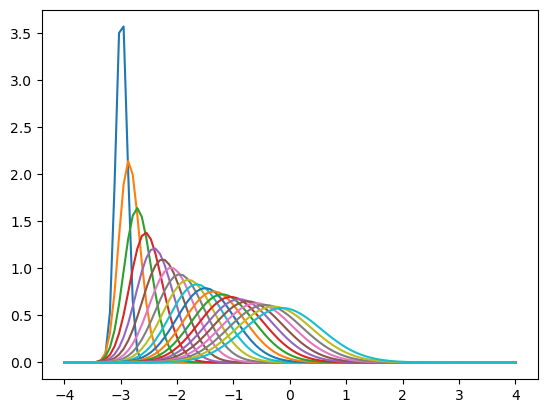

In [187]:
T = 200
xc = np.linspace(-4, 4, N)
xi = np.linspace(-4, 4, N+1)
ui = np.ones((N+1))
sc = np.zeros((N))


dt = 3 / 200


qc = norm.pdf(xc, loc=-3, scale=0.1)
TV = np.zeros((T))

rhomat = np.zeros((T, N))
for n in range(T):
    qc = advect_linear_slopes(qc, ui, sc, dt, dx, N, 0, 0)
    sc[1:-1] = (qc[2:] - qc[0:-2])/(2*dx)

    TV[n] = np.sum(np.abs(qc[1:] - qc[0:-1]))

    if (n % 10 == 0):
        plt.plot(xc, qc)
    rhomat[n, :] = qc

# seems to work ok, a little bit more diffusive than the previous scheme

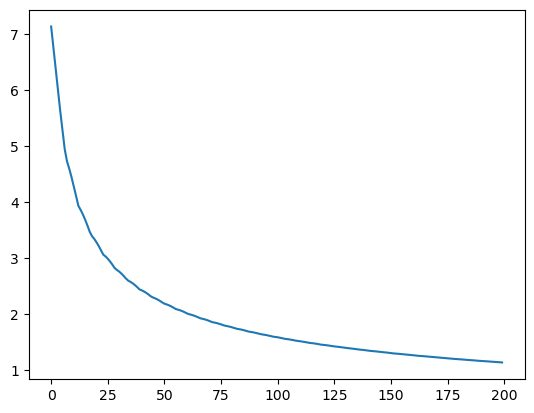

In [189]:
plt.plot(TV)
# total variation diminishing rapidly, i.e., the method is quite diffusive

In [174]:
def minmod(a,b):
    mm               = np.zeros_like(a)
    absa             = np.abs(a)
    absb             = np.abs(b)
    ab               = a*b
    mask             = np.logical_and(absa<absb,ab>0)
    mm[mask]         = a[mask]
    mask             = np.logical_and(absa>absb,ab>0)
    mm[mask]         = b[mask]
    return mm

def maxmod(a,b):
    mm               = np.zeros_like(a)
    absa             = np.abs(a)
    absb             = np.abs(b)
    ab               = a*b
    mask             = np.logical_and(absa<absb,ab>0)
    mm[mask]         = b[mask]
    mask             = np.logical_and(absa>absb,ab>0)
    mm[mask]         = a[mask]
    return mm

def minmodslope(q,dx):
    slope            = np.zeros_like(q)
    qc               = q[1:-1]
    ql               = q[:-2]
    qr               = q[2:]
    dql              = (qc-ql)/dx
    dqr              = (qr-qc)/dx
    sl[:]            = minmod(dql,dqr)
    return sl
    
def superbeeslope(q,dx):
    slope            = np.zeros_like(q)
    qc               = q[1:-1]
    ql               = q[:-2]
    qr               = q[2:]
    dql              = (qc-ql)/dx
    dqr              = (qr-qc)/dx
    sl1              = minmod(2*dql,dqr)
    sl2              = minmod(dql,2*dqr)
    sl[:]            = maxmod(sl1,sl2)
    return sl

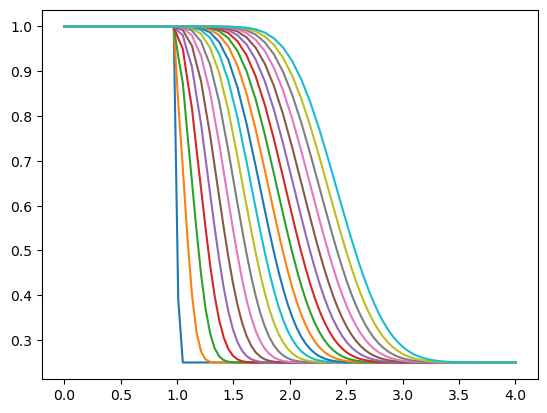

In [178]:
T = 200
xc = np.linspace(0, 4, N)
xi = np.linspace(0, 4, N+1)
ui = np.ones((N+1))
sc = np.zeros((N))
sc_LW = np.zeros((N))
sc_BW = np.zeros((N))


dt = 3 / 200

def init_rho(x):
    rho = np.ones((N)) * 0.25
    mask = x <= 1
    rho[mask] = 1.0
    return rho

qc = init_rho(xc)
TV = np.zeros((T))

rhomat = np.zeros((T, N))


for n in range(T):
    qc = advect_linear_slopes(qc, ui, sc, dt, dx, N, 1, 0.25)
    sc_LW[:-1] = (qc[1:] - qc[0:-1])/(dx)
    sc_BW[1:] = (qc[1:] - qc[0:-1])/(dx)

    
    sc[:] = minmod(sc_LW, sc_BW)
    TV[n] = np.sum(np.abs(qc[1:] - qc[0:-1]))

    if (n % 10 == 0):
        plt.plot(xc, qc)
    rhomat[n, :] = qc

# looks fine!

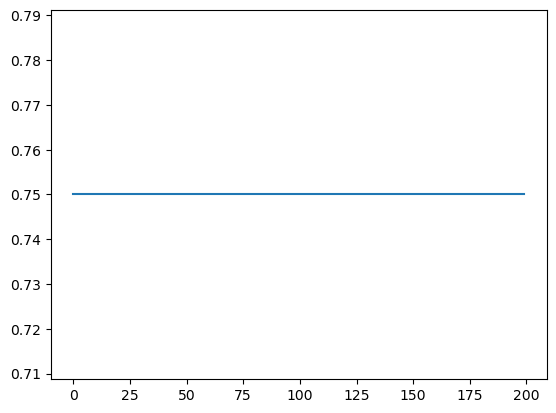

In [191]:
plt.plot(TV)

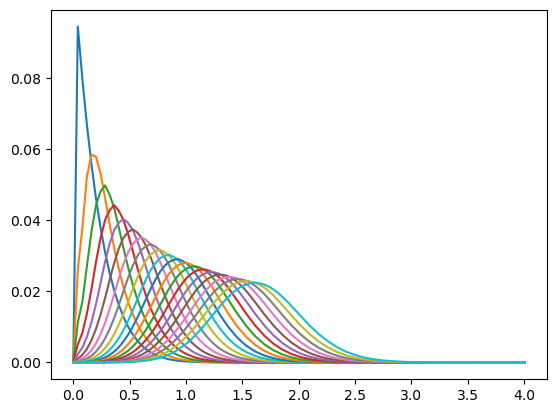

In [197]:
T = 200
xc = np.linspace(0, 4, N)
xi = np.linspace(0, 4, N+1)
ui = np.ones((N+1))
sc = np.zeros((N))
sc_LW = np.zeros((N))
sc_BW = np.zeros((N))
sc_1 = np.zeros((N))
sc_2 = np.zeros((N))


dt = 3 / 200

def init_rho(x):
    rho = np.ones((N)) * 0.25
    mask = x <= 1
    rho[mask] = 1.0
    return rho

qc = init_rho(xc)


qc = norm.pdf(xc, loc=-1, scale=0.5)
TV = np.zeros((T))

rhomat = np.zeros((T, N))


for n in range(T):
    qc = advect_linear_slopes(qc, ui, sc, dt, dx, N, 0, 0.0)
    
    sc_LW[:-1] = (qc[1:] - qc[0:-1])/(dx)
    sc_BW[1:] = (qc[1:] - qc[0:-1])/(dx)
    
    
    sc_1[:] = minmod(sc_LW, 2 * sc_BW)
    sc_2[:] = minmod(2* sc_LW, sc_BW)
    sc[:] = maxmod(sc_1, sc_2)
    #sc[:] *= 0
    
    TV[n] = np.sum(np.abs(qc[1:] - qc[0:-1]))

    if (n % 10 == 0):
        plt.plot(xc, qc)
    rhomat[n, :] = qc

# looks fine!

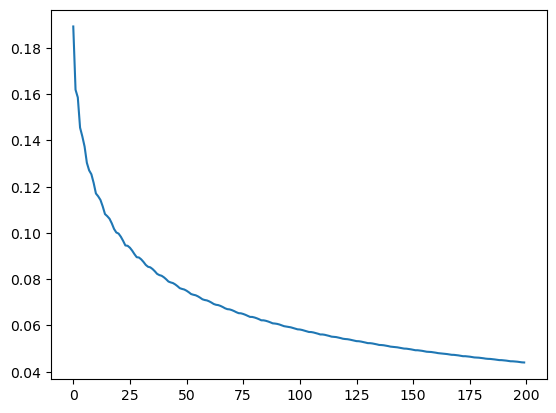

In [198]:
plt.plot(TV)

In [200]:
# the TDV looks to be decreasing for our tests, with different initial densities.
# definitely an improvement over Beam-Warming in the Heaviside-like step density case